In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import pycountry
import statsmodels.api as sm
import warnings
from statsmodels.stats.diagnostic import het_white
import statsmodels.formula.api as smf
from linearmodels import PanelOLS
from linearmodels import IV2SLS
from patsy import dmatrices

# Silencing future warnings to remove clutter
warnings.filterwarnings("ignore", category=FutureWarning)

# API Data Requests

## World Bank API
The data will be crawled by looping through multiple indicators from the World Bank API. The base year will be 2024, it will be a cross-sectional analysis


## Navigating Documentation
Indicator codes were discovered using https://data.worldbank.org/indicator/. Their descriptions were taken from multiple sources


## Indicators (Features)
GDP PPP, GDP Growth, Gini, Trade Openness, Education Expenditure and FDI Net inflows descriptions were taken from the World Development Indicators (World Bank, 2025). Rule of Law and Government Effectiveness descriptions were taken from the World Governance Indicators documentation (World Bank, 2024)

### GDP Per Capita $
GDP indicator divided by general population. This is the income per head in one accounting period. Expressed in dollars. Expressed in current prices, in dollars. Baseline metric for average income of a country's citizen.

### GDP Growth
Percentage change of GDP over each previous year using the constant price series (base year of 2015) in dollars. Baseline metric for growth of an economy.

### Gini Index
Measures how the distribution of income withing an economy deviates from a perfectly equal distribution. GINI index measures the area between an economy's Lorenz Curve and a line of absolute income equality, expressed as a percentage of the maximum area under the line. An index of 0 represents perfect equality and an index of 100 is perfect inequality.

### Education Expenditure (% GDP)
General government expenditure on education expressed as a percentage of GDP. General government refers to local, regional and central governments. Includes expenditure funded by transfers from international sources.

### Trade Openness (% GDP)
Trade is the sum of exports and imports of good and services in an economy. It is expressed as a percentage of GDP. A higher ratio means trade plays a bigger role in an economy. A lower ratio means trade players a lower role.

### Government Effectiveness
"Government effectiveness captures perceptions of the quality of public services, the quality of the civil service and the degree
of its independence from political pressures, the quality of policy formulation and implementation, and the credibility of the
government's commitment to such policies" (World Bank, 2024)

### Rule of Law
"Rule of law captures perceptions of the extent to which agents have confidence in and abide by the rules of society, and in particular the
quality of contract enforcement, property rights, the police, and the courts, as well as the likelihood of crime and violence" (World Bank, 2020)

### FDI Net Inflows (% GDP)
"Foreign direct investment are the net inflows of investment to acquire a lasting management interest (10 percent or more of voting stock) in an enterprise operating in an economy other than that of the investor. It is the sum of equity capital, reinvestment of earnings, other long-term capital, and short-term capital as shown in the balance of payments. This series shows net inflows (new investment inflows less disinvestment) in the reporting economy from foreign investors, and is divided by GDP." (World Bank, 2025)

# Roadblock
The code block below showcases a manual API querying method with manual pagination. A dictionary of indicators was looped over to produce a dataframe, the dataframe was appended to a list and then  the list was merged to a single data-frame. Ordinarily this should have worked but the World Bank's API was incredibly unreliable. Constant time-outs and exceptions did not allow for a completed dataframe of panel data to be produced. The only way forward was the pandas data reader library and specifically the wb module.

In [7]:
'''
indicators = {
    "GDP_Per_Capita" : "NY.GDP.PCAP.CD",
    "GDP_Growth" : "NY.GDP.MKTP.KD.ZG",
    "Gini_Index" : "SI.POV.GINI",
    "Education_Exp" : "SE.XPD.TOTL.GD.ZS",
    "Trade_Openness" : "NE.TRD.GNFS.ZS",
    "Govt_Effectiveness" : "GE.EST",
    "Rule_Of_Law" : "RQ.EST",
    "FDI_Net_Inflows" : "BX.KLT.DINV.WD.GD.ZS",
}

# Base URL of API requests
base_url = "https://api.worldbank.org/v2/country/all/indicator/{code}?date={year}&format=json&per_page=200&page={page}"

# Important fields here are, format=json and per_page=200. Page will be changed in the function

df_list = []

# Helper function to get the data with indicator and year parameters
def get_worldbank(indicator, year, page=1):
    try:
        url = base_url.format(code=indicator, year=year, page=page)
        response = requests.get(url, timeout=20)
    except:
        print("Exception Raised")
    return response.json()

for ind_name, ind_code in indicators.items():
    print(f"Now processing {ind_name}")
    json_data = get_worldbank(ind_code, 2022, 1)
    df = pd.DataFrame(json_data[1])
    # Keeping country column, country code and value for indicator
    df = df[['country', 'countryiso3code', 'value']]
    df['country'] = df['country'].apply(lambda x: x['value'])
    df = df.rename(columns={'value': ind_name, 'countryiso3code': 'iso3'})
    df_list.append(df)

# Same loop running for page 2 of results
for ind_name, ind_code in indicators.items():
    print(f"Now processing {ind_name}")
    json_data = get_worldbank(ind_code, 2022, 2)
    df = pd.DataFrame(json_data[1])
    # Keeping country column, country code and value for indicator
    df = df[['country', 'countryiso3code', 'value']]
    df['country'] = df['country'].apply(lambda x: x['value'])
    df = df.rename(columns={'value': k, 'countryiso3code': 'iso3'})
    df_list.append(df)

# Creating copy of first dataframe to merge country column later
df_copy = df_list[0][['iso3', 'country']].drop_duplicates()
dfs_final = []

# Iterating over indicators to find duplicate columns due to pagination
for ind in indicators:
    # In each iteration find columns with same indicator
    dfs_dupli = [df for df in df_list if ind in df.columns]
    # Concatenate row-wise
    combined = pd.concat(dfs_dupli, ignore_index=True)
    # Finding duplicate iso3 columns
    iso_cols = [col for col in combined.columns if col.startswith('iso3')]
    # Drop duplicate iso3 columns except the first
    combined = combined.drop(columns=iso_cols[1:])
    # Dropping duplicate iso3
    combined = combined.drop_duplicates(subset=['iso3'])
    # Append new dataframe to list
    dfs_final.append(combined)

# Removing country from every dataframe for a clean merge on iso3
for id, df in enumerate(dfs_final):
    if "country" in df.columns:
        dfs_final[id] = df.drop(columns=['country'])

# Take the first dataframe as the baseline to merge
merged = dfs_final[0]

# Can be seen to be the GDP Per Capita
merged.head()

# Iterating over remaining dataframes and merging on country
for df in dfs_final[1:]:
    # Merging on iso3
    merged = merged.merge(df, on='iso3', how="outer")

# Adding country column back
merged = merged.merge(df_copy, on='iso3', how='left')
# Adding country column to the very left
merged = merged[['country'] + [col for col in merged.columns if col!= 'country']]
# Print missing values
print(merged.isna().sum(), "\n")
# Print Shape
print(merged.shape, "\n")
'''

Now processing GDP_Per_Capita
Now processing GDP_Growth
Now processing Gini_Index
Now processing Education_Exp
Now processing Trade_Openness
Now processing Govt_Effectiveness
Now processing Rule_Of_Law
Now processing FDI_Net_Inflows
Now processing GDP_Per_Capita


NameError: name 'k' is not defined

# The improved API method
Using the wb module we loop similarly through all indicator to create a new dataframe with panel data over a period of 20 years. The year range chosen, 2002-2022, was done to maximise coverage. Of note here is that alongside the country name the ISO3 unique country identifier code was extracted. This was done to ease certain formatting issues later on as different datasets have different naming conventions, while the ISO3 remains the same for each nation.

In [104]:
from pandas_datareader import wb

# Copying the same indicator dictionary
indicators = {
    "GDP_Per_Capita" : "NY.GDP.PCAP.CD",
    "GDP_Growth" : "NY.GDP.MKTP.KD.ZG",
    #"Gini_Index" : "SI.POV.GINI",   Gini Index will be taken from an alternative dataset
    "Education_Exp" : "SE.XPD.TOTL.GD.ZS",
    "Trade_Openness" : "NE.TRD.GNFS.ZS",
    "Govt_Effectiveness" : "GE.EST",
    "Rule_Of_Law" : "RQ.EST",
    "FDI_Net_Inflows" : "BX.KLT.DINV.WD.GD.ZS",
}

# Getting list of ISO3 codes
countries = wb.get_countries()[['name', 'iso3c']]
countries = countries.rename(columns={"name": "Country", "iso3c": "iso3"})

# Empty list for dataframes
df_list = []

# Looping over indicators to download using wb module
for ind_name, ind_code in indicators.items():
    print(f"Processing {ind_name}")

    df = wb.download(
        indicator = ind_code,
        country = 'all',
        start = 2002,
        end = 2022,
    ).reset_index() # Resetting index for merge

    # Renaming columns
    df = df.rename(columns={
        'country' : 'Country', # Upper case
        ind_code : ind_name, # Indicator code to Indicator Name
    })

    # Attaching ISO3s
    df = df.merge(countries, on="Country", how="left")

    # Appending to dataframe list
    df_list.append(df)

# Taking first frame as baseline to merge
panel_wb = df_list[0]

# Looping over dfs, merging each one
for df in df_list[1:]:
    # Dropping country column
    df = df.drop(columns='Country')
    panel_wb = pd.merge(panel_wb, df, on=['iso3', 'year'], how='outer')

# Moving ISO3 to the very left
cols = panel_wb.columns.to_list()
cols = ['iso3'] + [c for c in cols if c != 'iso3']
panel_wb = panel_wb[cols]

Processing GDP_Per_Capita
Processing GDP_Growth
Processing Education_Exp
Processing Trade_Openness
Processing Govt_Effectiveness
Processing Rule_Of_Law
Processing FDI_Net_Inflows


In [105]:
panel_wb

,iso3,Country,year,GDP_Per_Capita,GDP_Growth,Education_Exp,Trade_Openness,Govt_Effectiveness,Rule_Of_Law,FDI_Net_Inflows
0,ABW,Aruba,2002,21307.248251,-0.944953,4.872200,133.230771,NaN,NaN,16.949056
1,ABW,Aruba,2003,21949.485996,1.110505,NaN,132.794291,NaN,NaN,7.816429
2,ABW,Aruba,2004,23700.631990,7.293728,4.356990,132.430930,1.281389,0.762954,-4.687639
3,ABW,Aruba,2005,24171.837133,-0.383138,4.623220,145.050280,1.287598,0.864074,-8.804936
4,ABW,Aruba,2006,24845.658484,1.127411,NaN,141.042627,1.279818,0.855287,8.920467
...,...,...,...,...,...,...,...,...,...,...
8227,NaN,Sub-Saharan Africa,2022,1696.439993,3.750658,3.097264,60.304783,NaN,NaN,1.804969
8228,NaN,Sub-Saharan Africa,2022,1696.439993,3.750658,3.097264,60.304783,NaN,NaN,3.381430
8229,NaN,Sub-Saharan Africa,2022,1696.439993,3.750658,3.097264,60.304783,NaN,NaN,1.804969
8230,NaN,Sub-Saharan Africa,2022,1696.439993,3.750658,3.097264,60.304783,NaN,NaN,3.381430


# Problems With The Data
There are a lot of missing values that we will have to impute. We can make the job easier by dropping the rows of invalid countries. Going through the dataset it can be seen how some panels are of regional data or other miscellaneous categories. We can drop them using the pycountry library. The library has a list of all ISO3 country codes which we extract as a set, for uniqueness. We filter the original dataset on the valid iso3 codes and then we drop 3717 rows which were invalid. We then check for any missing country name values and see that we don't have any.

In [43]:
# Getting ISO3 country codes from pycountry
# Creating set of all country iso3 codes from pycountry
iso3_correct = {c.alpha_3 for c in pycountry.countries}

# Rows before
before = panel_wb.shape[0]

# Filtering based on set and creating new frame
panel_wb_clean = panel_wb[panel_wb['iso3'].isin(iso3_correct)].copy()

#Reseting index
panel_wb_clean.reset_index(drop=True, inplace=True)

# Rows after
after = panel_wb_clean.shape[0]

# Printing how many rows we're dropping
print(f"We dropped {before-after} rows\n")

# Checking for empty country name rows
print(f"We are missing {panel_wb_clean['Country'].isna().sum()} country names")

We dropped 3717 rows

We are missing 0 country names


# Imputing missing values
First we check how many missing values we have

In [44]:
print(panel_wb_clean.isna().sum())

iso3                     0
Country                  0
year                     0
GDP_Per_Capita         129
GDP_Growth             185
Education_Exp         1539
Trade_Openness         738
Govt_Effectiveness     316
Rule_Of_Law            316
FDI_Net_Inflows        479
dtype: int64


# Gini Index Extraction
Gini data doesn't have much coverage from the API. This will be a huge issues later on because it is a key variable in a lot of our regressions. Since imputing a large number of values would completely destroy the natural variation in thr variable we will resort to an alternative dataset, the SWIID. This has coverage for almost all nations over a number of years (write more) The dataset is: https://fsolt.org/swiid/ https://dataverse.harvard.edu/file.xhtml?fileId=10797566&version=14.0

In [45]:
import zipfile, io
url = "https://dataverse.harvard.edu/api/access/datafile/10797566"

# Requesting the file, it is a zip
r = requests.get(url)
# Downloading bytes of the zip, turn bytes into file object and treat it as ZIP archive
z = zipfile.ZipFile(io.BytesIO(r.content))

# Finding the right file, it is swiid9_8/swiid9_8_summary.csv
print(z.namelist())

csv_name =  "swiid9_8/swiid9_8_summary.csv"
# Reading into pandas
swiid = pd.read_csv(z.open(csv_name))


['swiid9_8/', 'swiid9_8/swiid9_8.rda', 'swiid9_8/stata_swiid.pdf', 'swiid9_8/R_swiid.pdf', 'swiid9_8/swiid9_8_summary.csv', 'swiid9_8/swiid9_8.dta']


# Merging the two datasets

## Creating the ISO3 column
We will need to merge on ISOs and year. Firstly we have to check for any discrepancies in the country names between the two datasets. This could either be caused by missing country panels or due to different naming conventions. We take the difference between the two sets and see that there are some discrepancies. We then create a helper function to get the ISO3s from the pycountry library and apply it to the country name column of SWIID dataset. After doing so we still see there are some missing values due to defunct countries (the dataset has coverage spanning decades) and some minor naming differences. We create another dictionary of all the proper naming and ISOs and apply it to the dataframe. We now have two dataframes that we can merge on year and country

In [46]:
# Creating sets from the two country columns
swiid_set = set(swiid['country'].unique())
wb_set = set(panel_wb_clean['Country'].unique())

# Finding set difference
set_diff = swiid_set - wb_set
print("In SWIID but not in merged dataframe")
print(set_diff)
print(f"Missing {len(set_diff)} countries\n")

# Creating iso3 getter helper function
def get_iso3(name):
    try:
        return pycountry.countries.lookup(name).alpha_3     #alpha_3 gives ISO3
    except:
        return None

# Creating iso3 column for swiid to merge
swiid['iso3'] = swiid['country'].apply(get_iso3)

# Seeing if we are missing
print(f"{swiid['iso3'].isna().sum()} missing ISO3s\n")

# Dropping countries that no longer exist
defunct_countries = ['Czechoslovakia', 'Yugoslavia', 'Soviet Union']
swiid = swiid[~swiid['country'].isin(defunct_countries)]

# Creating dictionary
iso_swiid_dict = {
    "Egypt": "EGY",
    "Micronesia": "FSM",
    "Venezuela": "VEN",
    "St. Vincent and Grenadines": "VCT",
    "Palestinian Territories": "PSE",
    # Democratic Republic
    "Congo-Kinshasa": "COD",
    "Anguilla": "AIA",
    "Turkey": "TUR",
    "Iran": "IRN",
    "Laos": "LAO",
    "Kyrgyzstan": "KGZ",
    "Cape Verde": "CPV",
    "Vietnam": "VNM",
    "Côte d'Ivoire": "CIV",
    "Tanzania": "TZA",
    "Kosovo": "XKX",
    # Republic
    "Congo-Brazzaville": "COG",
    "Czech Republic": "CZE",
    "Russia": "RUS",
    "Gambia": "GMB",
    "Korea": 'KOR',
    "Taiwan": "TWN",
    "Hong Kong": "HKG",
    "Bahamas": "BHS",
    "São Tomé and Príncipe": "STP",
    "St. Lucia": "LCA",
    "Brunei": "BRN",
    "St. Kitts and Nevis": "KNA",
    "Syria": "SYR"
}

# Mapping dictionary to missing iso3 values
swiid['iso3'] = swiid['iso3'].fillna(
    swiid['country'].map(iso_swiid_dict)
)

print(f"{swiid['iso3'].isna().sum()} missing ISO3s\n")

In SWIID but not in merged dataframe
{'Turkey', 'Korea', 'Taiwan', "Côte d'Ivoire", 'Venezuela', 'Laos', 'Iran', 'Hong Kong', 'Cape Verde', 'Congo-Brazzaville', 'Micronesia', 'Kyrgyzstan', 'São Tomé and Príncipe', 'Vietnam', 'Soviet Union', 'St. Vincent and Grenadines', 'Bahamas', 'Palestinian Territories', 'Russia', 'Slovakia', 'Yugoslavia', 'Gambia', 'Czechoslovakia', 'Congo-Kinshasa', 'Czech Republic', 'Somalia', 'Egypt', 'Kosovo', 'Yemen', 'Puerto Rico', 'Anguilla', 'Brunei', 'Syria'}
Missing 33 countries

341 missing ISO3s

0 missing ISO3s



## Merging on Year and ISO3
Firstly we check if the two dataframes have the same data type for year. Our panel dataframe doesn't, we change it so we can merge. We can then extract the columns we need from SWIID: ISO3, Year and Gini. We then merge the two dataframes on ISO3 and Year.

In [47]:
print(swiid.info(),'\n')
print(panel_wb_clean.info(), '\n')

# Changing datatype of year to integer
panel_wb_clean['year'] = panel_wb_clean['year'].astype(int)

<class 'pandas.core.frame.DataFrame'>
Index: 6344 entries, 0 to 6397
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       6344 non-null   object 
 1   year          6344 non-null   int64  
 2   gini_disp     6344 non-null   float64
 3   gini_disp_se  6344 non-null   float64
 4   gini_mkt      6344 non-null   float64
 5   gini_mkt_se   6344 non-null   float64
 6   abs_red       2685 non-null   float64
 7   abs_red_se    2685 non-null   float64
 8   rel_red       2685 non-null   float64
 9   rel_red_se    2685 non-null   float64
 10  iso3          6344 non-null   object 
dtypes: float64(8), int64(1), object(2)
memory usage: 594.8+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4515 entries, 0 to 4514
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   iso3                4515 non-null   object 
 1   Country  

In [48]:
# Extracting just iso3, gini column and year
swiid_gini = swiid[['iso3', 'year', 'gini_disp']].copy()

# Merging dataset on year and iso3 (if condition for replicability)
if "Gini_Index" not in panel_wb_clean.columns:
    panel_wb_clean = panel_wb_clean.merge(swiid_gini, on=['iso3','year'], how='left')
    # Renaming column to Gini_Index
    panel_wb_clean = panel_wb_clean.rename(columns={'gini_disp' : 'Gini_Index'})

# Displaying missing Gini rows
print(f"{panel_wb_clean['Gini_Index'].isna().sum()} missing Gini values")

1305 missing Gini values


# Imputation (for Regressions)

## Bias-Variance Tradeoff
When imputing we are essentially creating new data which can bias our regression estimates. Conversely, listwise deletion (dropping country/year rows where any variable isn't filled) which is the only alternative would lead to incredibly small samples which could lead to huge estimated coefficient variances. As the sample shrinks massively, standard errors skyrocket and the estimates lose all precision. Additionally, inspecting the dataset we see that most missing values are coming from poorer regions or smaller countries in population; this would be a huge source of bias as it is in effect introducing sample selection bias, biasing towards richer and bigger countries.

On the other hand imputation also introduces some attenuation bias and measurement error. This is because imputed values have inherently less variability as they are inferred from other observations within the year range. If a few years are missing then the observations inferred may be: (i) close to the true values (minimal measurement error) and (ii) follow the natural variability of the variable (e.g. GDP Per capita is evolving smoothly year-by-year). If however a lot of years are missing then the imputation may:  (i) severely reduces the natural variance of the regressors as it has a constrained range of values to infer from, shrinking estimated coefficients towards 0 (attenuation bias) and (ii) over-estimate or under-estimate leading to considerable measurement error bias.

In conclusion while imputation introduces some bias and reduces variation in the data, due to the sheer amount of missing values, the alternative of dropping all missing rows would also lead to considerable bias and unreliable estimates. This is why the imputed dataset will be used in regressions.

## Imputation Method
Since we aim to reduce attenuation bias and measurement error a simple median or mean imputation over 1000s of values would not be appropriate. Many countries would simply receive whole columns of the exact same value, massively reducing the natural variation of the regressors along with the natural cross-country variation of the dataset. Multiple countries, regardless of previous or historical values, would receive the same values which would make normally heterogenous panels seem homogenous.


We will use linear interpolation since it is the most appropriate method for preserving within-country variation, across time. (e.g. GDP per capita of X country seems to evolve smoothly, so linear approximation could preserve some of the natural variation). The caveat here is that interpolating always produces smooth, linear trends as it is essentially a linear function between two observations, it cannot predict volatility and may reduce the natural variance of a volatile regressor such as GDP growth. Although linear interpolation also reduces the natural variance of our features it does so less than other imputation methods.

## Interpolation
Linear interpolation will be used for variables that are very persistent, meaning they don't change much year by year and are considered "smooth". To discover those variables we will first lag the variable by 1 year then calculate the correlation between its current and lagged value. A high correlation means it is persistent and linear interpolation can be used. Linear interpolation will also be used for variables that don't have a lot of missing values such as GDP_Per_Capita and GDP_Growth since these won't cause too much variation to be lost.

An important caveat here is that even though our interpolation handles edge cases (first or last years missing) through *limit_direction='both'*, when a whole year column is missing then nothing can be interpolated. We expect some values to remain missing.

### Interpolation for strongly persistent variables
Missing rows will be imputed using linear interpolation. If the variable is persistent within years then this means our process of data creation remains faithful to the trajectory of the variable assuming the variable follows a linear trend.

### Interpolation for intermediate and weak persistence
For missing rows with weak or intermediate persistence we will not interpolate all rows, only those that are up to a limit of consecutive missing years. The limit is set to 3 but it can be further fine-tuned.

In [49]:
# Creating copy of raw dataframe
panel_wb_imputed = panel_wb_clean.copy()

# Creating helper function for calculating persistence
def var_persistence(df, var):
    # Making sure the years and countries are sorted
    df = df.sort_values(['iso3', 'year'])

    # Creating a lagged variable column
    df[f"{var}_Lag1"] = df.groupby("iso3")[var].shift(1)

    # Calculating correlation and extracting value from matrix
    corr = df[[var,f"{var}_Lag1"]].corr().iloc[0, 1]

    # Returning correlation
    return corr

# Creating list of numeric columns
numeric_cols = panel_wb_imputed.select_dtypes(include='number').columns.to_list()

# Looping over columns to see persistence and adding column names to list based on persistence
for col in numeric_cols:
    pers = var_persistence(panel_wb_imputed, col)
    print(f"Persistence: {col} : {pers}\n")
    # Checking for high persistence (0.85) and applying interpolation to all rows
    if pers > 0.85:
        panel_wb_imputed[col] = panel_wb_imputed.groupby('iso3')[col].transform(
            lambda c : c.interpolate(limit_direction='both'))
    # Checking for intermediate persistence (0.5) and applying interpolation to up to 3 consecutive missing rows
    elif pers > 0.5:
        panel_wb_imputed[col] = panel_wb_imputed.groupby('iso3')[col].transform(
            lambda c : c.interpolate(limit=3, limit_direction='both'))
    # Otherwise the persistence is weak and only interpolate up to 1 consecutive missing row
    else:
        panel_wb_imputed[col] = panel_wb_imputed.groupby('iso3')[col].transform(
            lambda c : c.interpolate(limit=1, limit_direction='both'))

Persistence: year : 1.0

Persistence: GDP_Per_Capita : 0.9922677449132742

Persistence: GDP_Growth : 0.16842811933395918

Persistence: Education_Exp : 0.9320056635588188

Persistence: Trade_Openness : 0.9633594025337419

Persistence: Govt_Effectiveness : 0.990598337558557

Persistence: Rule_Of_Law : 0.991733392709829

Persistence: FDI_Net_Inflows : 0.5900266147622736

Persistence: Gini_Index : 0.9991886574691943



In [50]:
# Finding total sum of sums of missing values on raw dataset
before_missing = sum(panel_wb_clean.isna().sum())
# Finding total sum of sums of missing values on processed dataset
after_missing = sum(panel_wb_imputed.isna().sum())

print(f"We have filled in {before_missing - after_missing} values\n")

# Checking which are still missing
panel_wb_imputed.isna().sum()

We have filled in 2559 values



iso3                    0
Country                 0
year                    0
GDP_Per_Capita         63
GDP_Growth            167
Education_Exp         336
Trade_Openness        483
Govt_Effectiveness    231
Rule_Of_Law           231
FDI_Net_Inflows       412
Gini_Index            525
dtype: int64

In [51]:
# Saving raw dataset
panel_wb_clean.to_csv("wb_raw.csv", index=False)

# Saving imputed dataset
panel_wb_imputed.to_csv("wb_imputed.csv", index=False)

# Exploratory Analysis
We will calculate descriptive statistics, ranges, variances and standard deviations of each column

## Descriptive Statistics
We can learn a lot from descriptive statistics apropos outliers, skewness, distributions and economic interpretations of extreme values. Taking GDP per capita as an example we see the mean to be 16,343 and the median to be 1,649. This tells us that it is a very righly skewed distribution which is also very spread out, from the huge standard deviation value of 25,082. The ranges tell us a story of extreme global wealth inequality, the maximum 226,052 is far above the mean and even further from the minimum value of just 109. The latter signifies extreme levels of poverty. We can also tell which columns are approximately normally distributed by looking at the mean, max, min and standard deviation. Take Government Effectiveness for example (-2.44, 0.0, 2.46, 0.99), these values by themselves can inform us on the distribution which broadly follows a normal one. The count can inform us on how many rows we are missing for each variable, for example Education Expenditure has far fewer values available than GDP Growth. As for extreme values, we can take the example from GDP growth of -54%. This is an extreme outlier which tells us a story of potential political instability, war or a depressive episode.

In [4]:
# Importing raw dataset
wb_raw = pd.read_csv("wb_raw.csv")

# Importing imputed dataset
wb_imputed = pd.read_csv("wb_imputed.csv")

# Excluding year column from analysis
wb_stat = wb_raw.copy()
wb_stat.drop(columns='year', inplace=True)

# Descriptive statistics
print("--------Descriptive Stats--------")
print(f"{wb_stat.describe()}\n")

--------Descriptive Stats--------
       GDP_Per_Capita   GDP_Growth  Education_Exp  Trade_Openness  \
count     4386.000000  4330.000000    2976.000000     3777.000000   
mean     16343.139799     3.325970       4.386914       91.125718   
std      25082.645980     6.009641       1.971352       59.278484   
min        109.593814   -54.336106       0.000004        2.698834   
25%       1649.323704     1.169075       3.071372       55.784126   
50%       5656.586863     3.537641       4.199421       78.814980   
75%      21303.481866     5.997803       5.372008      108.869117   
max     226052.001905    91.137039      16.230376      863.195099   

       Govt_Effectiveness  Rule_Of_Law  FDI_Net_Inflows   Gini_Index  
count         4199.000000  4199.000000      4036.000000  3210.000000  
mean            -0.028098    -0.028528         9.442848    38.649533  
std              0.996390     0.996695        64.892966     7.923534  
min             -2.440229    -2.547726     -1303.108267    2

## Ranges, Variances and Standard Deviations
Much of the discussion on ranges and standard deviations was given above but it is easier to discern which values follow a neatly distributed (approximately normal) distribution more easily from the Series below. For ranges, Government Effectiveness and Rule of Law can be seen to have a tight range of approximately 5. GDP Per Capita has the highest range which is to be expected since it is a dollar amount, while most other variables are expressed as a percentage (e.g. of GDP) or follow a scaled interval by design. GDP Growth having such a high range when we expect most absolute growth values to not exceed 10 signifies extreme outliers that may have to be dropped

Variances aren't very useful for interpretation as the values are in squared units and grow exponentially, giving us some tiny and some huge values. It can give us a rough idea of which variables are spread out more around the mean, for example Government Effectiveness has a variance less than 1 and GDP Per Capita has a variance in the hundreds of millions, so we can confidently say GDP Per Capita has a far higher spread. Standard deviations are interpretable though and we can confirm our previous suspicions on which variables were more spread around the mean, with GDP Per Capita predictably having the highest and Government Effectiveness having the lowest. Taking the latter, a standard deviation of approximately 1 tells us most values lie between +1 and -1 of the mean, there is not much spread in the data. The former tell us that most values lie between +25,082 and -25,082 of the mean, immediately signifying that GDP per capita is expressed in Level units and has very large spread around the mean.

In [53]:
# Finding range of each value
range_df = wb_stat.max(numeric_only=True) - wb_stat.min(numeric_only=True)
print("--------Ranges--------")
print(f"{range_df}\n")

# Variance and Standard Deviations
print("--------Variance--------")
print(f"{wb_stat.var(numeric_only=True)}\n")
print("--------Standard Deviations--------")
print(f"{wb_stat.std(numeric_only=True)}\n")

--------Ranges--------
GDP_Per_Capita        225942.408092
GDP_Growth               145.473145
Education_Exp             16.230372
Trade_Openness           860.496265
Govt_Effectiveness         4.909889
Rule_Of_Law                4.799961
FDI_Net_Inflows         3012.935499
Gini_Index                42.700000
dtype: float64

--------Variance--------
GDP_Per_Capita        6.291391e+08
GDP_Growth            3.611579e+01
Education_Exp         3.886229e+00
Trade_Openness        3.513939e+03
Govt_Effectiveness    9.927937e-01
Rule_Of_Law           9.934014e-01
FDI_Net_Inflows       4.211097e+03
Gini_Index            6.278239e+01
dtype: float64

--------Standard Deviations--------
GDP_Per_Capita        25082.645980
GDP_Growth                6.009641
Education_Exp             1.971352
Trade_Openness           59.278484
Govt_Effectiveness        0.996390
Rule_Of_Law               0.996695
FDI_Net_Inflows          64.892966
Gini_Index                7.923534
dtype: float64



## Correlations
We will construct a correlation matrix to discover multicolinearity in our columns so that we can obtain meaningful OLS estimates later on by not regressing highly correlated variables together. A helper function was created to make the distinction easier, setting a cutoff of 0.7 in absolute value (for both positive and negative correlation) to distinguish highly correlated variables. Two problematic correlations were found: GDP Per Capita with Govt Effectiveness and Govt Effectiveness with Rule of Law.

In [54]:
# Selecting all numeric columns
num = wb_raw[[col for col in wb_stat.columns if col != "Country"
              and col !="year" and col != 'iso3']]

# Correlation Matrix
corr = wb_stat.corr(numeric_only=True)
print(corr, "\n")

# Finding highly correlated variables to avoid multicolinearity in regressions later on

# Creating empty list of corr values to check for duplicates
corr_values = []

# Looping over columns to find correlations which exceed threshold
for col1 in num.columns:
    for col2 in num.columns:
        if col1 != col2:
            corr_value = corr.loc[col1, col2]
            # Cutoff is set at 0.7, absolute value for both negative and positive correlation
            if abs(corr_value) > 0.7 and corr_value not in corr_values:
                print(f"{col1} with {col2}: {abs(corr_value)}")
                corr_values.append(corr_value)

                    GDP_Per_Capita  GDP_Growth  Education_Exp  Trade_Openness  \
GDP_Per_Capita            1.000000   -0.080560       0.031910        0.331867   
GDP_Growth               -0.080560    1.000000      -0.114820        0.015903   
Education_Exp             0.031910   -0.114820       1.000000        0.067384   
Trade_Openness            0.331867    0.015903       0.067384        1.000000   
Govt_Effectiveness        0.700918   -0.105384       0.246728        0.366019   
Rule_Of_Law               0.664790   -0.109726       0.153606        0.343844   
FDI_Net_Inflows           0.245313    0.000170      -0.022534        0.200137   
Gini_Index               -0.496290    0.085503      -0.165906       -0.249229   

                    Govt_Effectiveness  Rule_Of_Law  FDI_Net_Inflows  \
GDP_Per_Capita                0.700918     0.664790         0.245313   
GDP_Growth                   -0.105384    -0.109726         0.000170   
Education_Exp                 0.246728     0.153606   

# Histograms

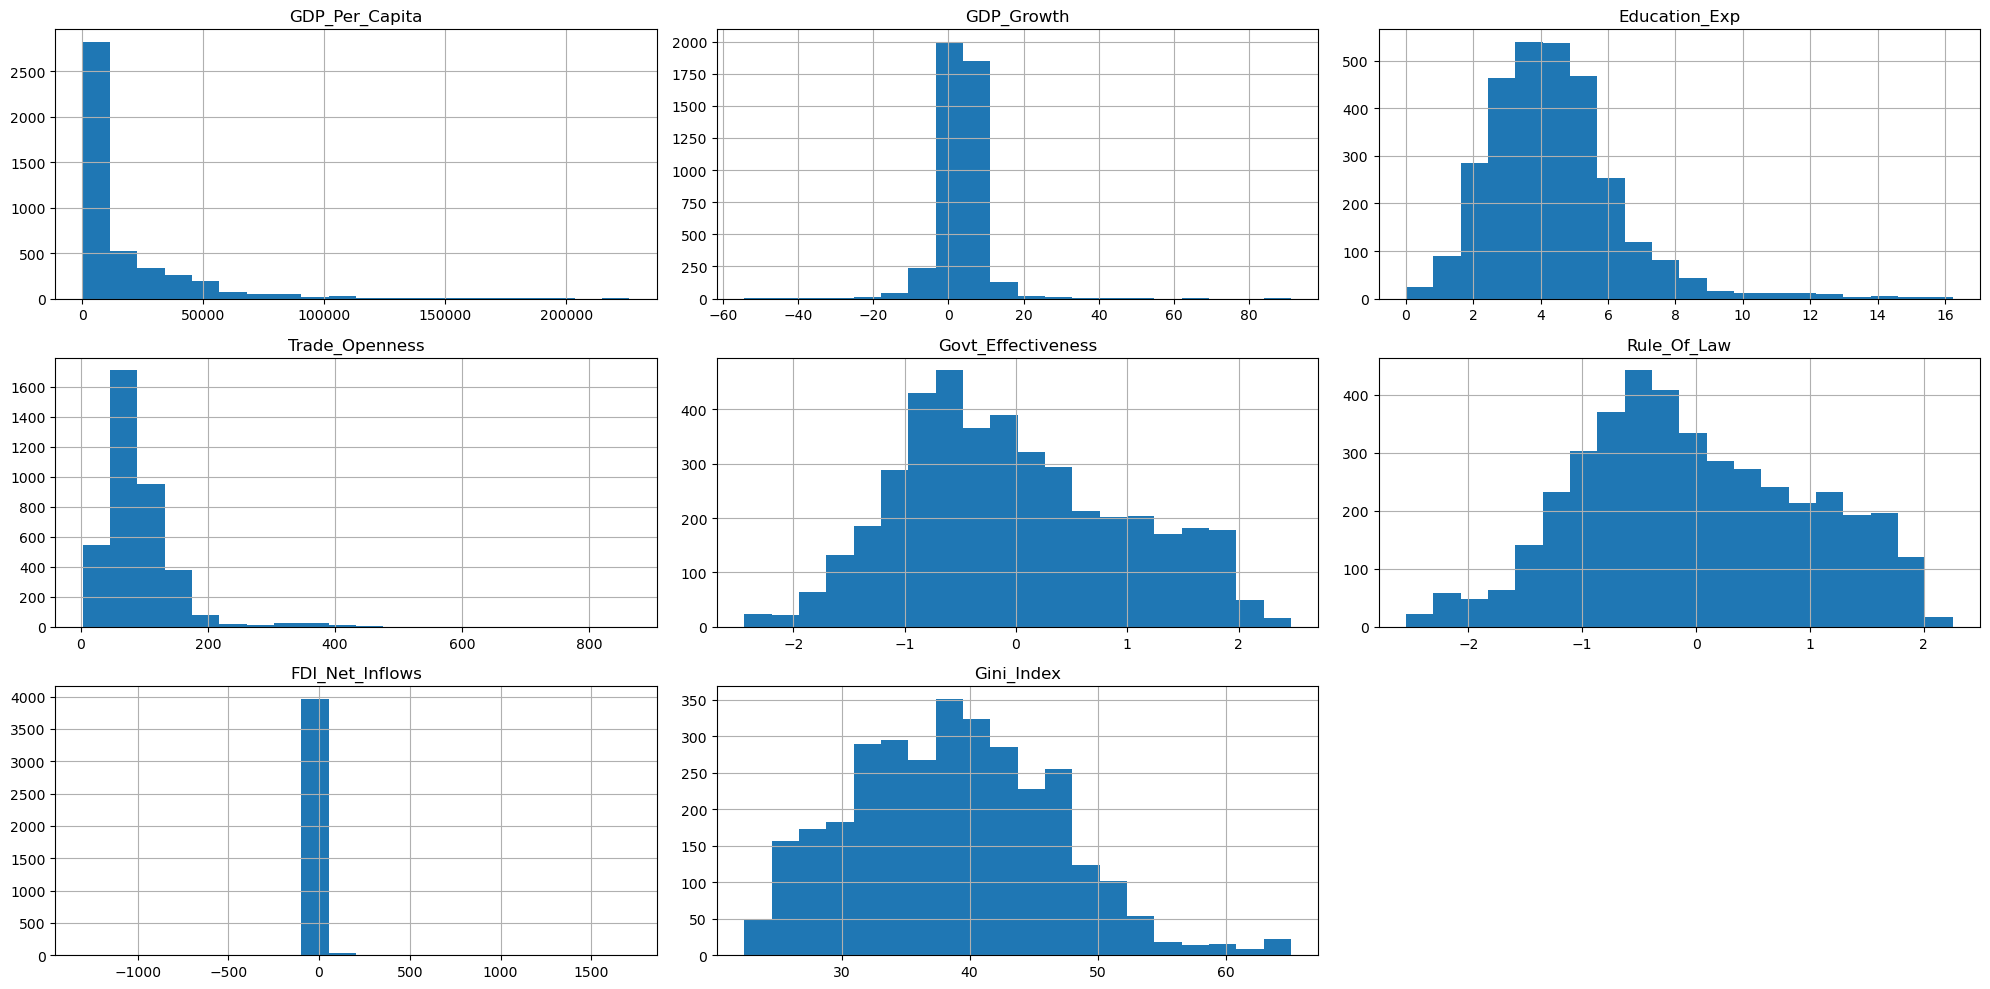

In [55]:
# Histograms

num.hist(figsize=(20, 10), bins=20)
plt.tight_layout()
plt.show()

## Interpretation of Histograms and Transformation Implications
We can observe that GDP Per Capita, Trade Openness, Education Expenditure and particularly FDI Inflows are heavily skewed. Wooldridge (2015, p. 172) presents the argument that taking a log transformation of skewed variables can: (i) eliminate or mitigate heteroskedasticity, (ii) narrow a variable's range and (iii) make OLS estimates less sensitive to outliers. He also notes that it is a "standard rule of thumb" (Ibid.) to take logs of positive dollar amounts such as GDP per Capita.

Log transformations have the additional quality of making a distribution more symmetric, approaching a normal distribution. This makes the MLR.6 assumption of homoskedastic error terms more plausible and can lead to more reliable inference. Regardless of this, heteroskedasticity tests will be run. A lot of these variables also have extreme outliers which we will have to reassess after the log transformations, it may be appropriate to trim them.

# Feature Engineering

## Log transformations
GDP per capita, Trade Openness, Education Expenditure and FDI Inflows will be logarithmically transformed to alleviate the issues of skewness and extreme outliers. All terms but FDI inflows are strictly positive so there is no issue to take logarithms. To take logarithms of FDI inflows when some of the data is negative we will need an inverse hyperbolic sine transformation given by the formula:
$$
\operatorname{asinh}(x) = \ln\left(x + \sqrt{x^{2} + 1}\right)
$$

This is used over a standard sign log transformation since it allows for: (i) retaining meaningful zero-value observations (ln(0) is undefined), (ii) retaining negative-value observations and (iii) avoids the inclusion of arbitrary constants such as in log(1+x) transformations. (Bellemare and Wichman, 2020, p.50)
## Gini

The economic theory we rely on to transform the Gini Index is the Kuznets curve. Following Kuznets (1955) and Banerjee and Dufflo (2003, p. 275), the relation between inequality and growth has an inverted U-shape. This means that countries with either very high or very low inequality record lower levels of growth. This non-linear effect is captured through a squared term.


To introduce a non-linear term into an equation that is linear in parameters we will create a new variable Gini_Sq, which is simply taking Gini's observations and squaring them. This allows the model to retain its Classical Linear Regression (CLR) properties, its traditional R^2 properties and the standard hypothesis tests remain valid (Kennedy, 2008, p. 96)

## Interaction Terms

Add Theory


In [5]:
# Sign Log Transforming FDI_Net_Inflows
# Applying arcinsh function - manual approach np.log(fdi + (np.sqrt(fdi**2 + 1)))
wb_raw["FDI_Log"] = np.arcsinh(wb_raw['FDI_Net_Inflows'])

# Log Transformations of skewed features
wb_raw["GDP_Pc_Log"] = np.log(wb_raw["GDP_Per_Capita"])
wb_raw["Trade_Log"] = np.log(wb_raw["Trade_Openness"])
wb_raw['Educ_Log'] = np.log(wb_raw['Education_Exp'])

# Polynomial feature
wb_raw['Gini_Sq'] = wb_raw["Gini_Index"]**2

# Interaction Terms
wb_raw["GDP_Govt_Eff"] = wb_raw["GDP_Pc_Log"] * wb_raw["Govt_Effectiveness"]
wb_raw["GDP_Law"] = wb_raw["GDP_Pc_Log"] * wb_raw["Rule_Of_Law"]
wb_raw["Educ_Govt_Eff"] = wb_raw["Educ_Log"] * wb_raw["Govt_Effectiveness"]
wb_raw["GDP_Growth_Trade"] = wb_raw["GDP_Growth"] * wb_raw["Trade_Openness"]
wb_raw['Trade_Law'] = wb_raw['Trade_Log'] * wb_raw['Rule_Of_Law']

# Performing the same transformations on imputed df
wb_imputed["FDI_Log"] = np.arcsinh(wb_imputed['FDI_Net_Inflows'])
wb_imputed["GDP_Pc_Log"] = np.log(wb_imputed["GDP_Per_Capita"])
wb_imputed["Trade_Log"] = np.log(wb_imputed["Trade_Openness"])
wb_imputed['Educ_Log'] = np.log(wb_imputed['Education_Exp'])
wb_imputed['Gini_Sq'] = wb_imputed["Gini_Index"]**2
wb_imputed["GDP_Govt_Eff"] = wb_imputed["GDP_Pc_Log"] * wb_imputed["Govt_Effectiveness"]
wb_imputed["GDP_Law"] = wb_imputed["GDP_Pc_Log"] * wb_imputed["Rule_Of_Law"]
wb_imputed["Educ_Govt_Eff"] = wb_imputed["Educ_Log"] * wb_imputed["Govt_Effectiveness"]
wb_imputed["GDP_Growth_Trade"] = wb_imputed["GDP_Growth"] * wb_imputed["Trade_Openness"]
wb_imputed['Trade_Law'] = wb_imputed['Trade_Log'] * wb_imputed['Rule_Of_Law']


# Economic Questions
### Colinear variables reminder
(GDP Per Capita, Govt Effectiveness), (Govt Effectiveness, Rule of Law)

### Interaction terms reminder
(GDP Per Capita, Govt Effectiveness), (GDP Per Capita, Rule of Law), (Education Expenditure, Government effectiveness),
(GDP Growth, Trade Openness)

## 1. Do more unequal income distributions affect an economy's growth?
Between country question taking an average of 5 years [2015-2019]

Explained variable: GDP_Growth

Main explanatory variable: Gini_Index, Gini_sq

Controls: GDP_Pc_Log, Educ_Log, Trade_Log, Govt_Effectiveness, (Educ_Govt_Eff) -> interaction

$$
\begin{aligned}
\overline{\text{GDP\_Growth}}_{i}
&= \beta_0
+ \beta_1 \,\overline{\text{Gini}}_{i}
+ \beta_2 \,\overline{\text{Gini}}^{\,2}_{i}
+ \beta_3 \log(\overline{\text{GDP\_Pc}}_{i})
+ \beta_4 \log(\overline{\text{Educ\_Exp}}_{i}) \\
&\quad
+ \beta_5 \log(\overline{\text{Trade}}_{i})
+ \beta_6 \,\overline{\text{Govt\_Effectiveness}}_{i}
+ \beta_7 \left(\overline{\text{Educ\_Exp}}_{i} \times \overline{\text{Govt\_Effectiveness}}_{i}\right)
+ \text{ε}_{i}
\end{aligned}
$$


## 2. Does greater international trade integration **within a country** lead to higher FDI inflows?
Within-country question with fixed effects

Explained variable: FDI_Log

Main Explanatory variable: Trade_log

Controls: GDP_Pc_Log, Gini_Index, Gini_sq, Rule_Of_Law, (GDP_Law, Trade_Law)

$$
\begin{aligned}
\log(\text{FDI}_it)
&= \beta_0
+ \beta_1 \log(\text{Trade}_{it})
+ \beta_2 \log(\text{GDP\_Pc}_{it})
+ \beta_3 \,\text{Gini}_{it}
+ \beta_4 \,\text{Gini}^2_{it}
+ \beta_5 \,\text{Rule\_Of\_Law}_{it}
\\[1em]
&\quad
+ \beta_6 \left( \text{Rule\_Of\_Law}_{it} \times \log(\text{GDP\_Pc}_{it}) \right)
+ \beta_7 \left( \log(\text{Trade}_{it}) \times \text{Rule\_Of\_Law}_{it} \right)
+  \text{α}_{i}
+  \text{λ}_{t}
+ \text{ε}_{it}
\end{aligned}
$$


## 3. Does higher spending on education **within a country** translate to increased growth?
Within-country question with fixed effects

Explained variable: GDP_Growth

Main explanatory variable: Educ_Log

Controls: Trade_Log, Gini_Index, Gini_sq, Govt_Effectiveness, (Educ_Govt_Eff)

$$
\begin{aligned}
\text{GDP\_Growth}_{it}
&= \beta_0
+ \beta_1 \,\text{Educ\_Log}_{it}
+ \beta_2 \,\text{Trade\_Log}_{it}
+ \beta_3 \,\text{Gini\_Index}_{it}
+ \beta_4 \,\text{Gini\_sq}_{it}
+ \beta_5 \,\text{Govt\_Effectiveness}_{it}
\\[1em]
&\quad
+ \beta_6 \left( \text{Educ\_Log}_{it} \times \text{Govt\_Effectiveness}_{it} \right)
+ \text{α}_{i}
+  \text{λ}_{t}
+ \text{ε}_{it}
\end{aligned}
$$


## 4. Did the COVID-19 pandemic have a smaller negative effect on GDP growth in countries with more efficient governments?
Between country question using difference in differences
Explained variable: GDP_Growth

Main explanatory variable: Govt_Effectiveness^PRE (pre-covid average), Interaction term: Post (dummy) * Govt_Effectiveness^PRE

Controls: Trade_Log, Gini_Index, Gini_Sq, Educ_Log

Fixed Effects: Country FEs μ, Year FEs λ

$$
\begin{aligned}
\text{GDP\_Growth}_{it}
&= \beta_0
+ \beta_1 \,\text{Post}_t
+ \beta_2 \,\overline{\text{Govt\_Effectiveness}}_{i}^{\,\text{pre}}
+ \beta_3 \left( \text{Post}_t \times \overline{\text{Govt\_Effectiveness}}_{i}^{\,\text{pre}} \right) \\
&\quad
+ \beta_4 \,\text{Trade\_Log}_{it}
+ \beta_5 \,\text{Gini\_Index}_{it}
+ \beta_6 \,\text{Gini\_sq}_{it}
+ \beta_7 \,\text{Educ\_Log}_{it} \\
&\quad
+ \mu_i + \lambda_t
+ \text{ε}_{i}
\end{aligned}
$$



# Scatterplot of Gini with GDP Growth
To justify our inclusion of a polynomial term and to confirm the above-mentioned economic theory we will construct a scatterplot of GDP Growth on Gini and see if the relationship is non-linear. We will first filter the data within the year range 2015-2019 and then take the average, thereby fixing the time dimension and only allowing between-country variation to show in the plot and later in the regression. First we construct an outlier trimmer helper function to fix the scale of the axes and make the graph interpretable. (extreme values lead to unrealistic ranges than "shrinks" the meaningful part of the graph)

In [6]:
# Creating outlier trimming helper function
def trim_out(df, cols, lower_bound=0.01, upper_bound=0.99):

    df_trim = df.copy()

    for col in cols:
        # Calculating lower quartile
        low = df_trim[col].quantile(lower_bound)
        # Calculating upper quartile
        high = df_trim[col].quantile(upper_bound)
        # Filtering dataset
        df_trim = df_trim[(df_trim[col] >= low) & (df_trim[col] <= high)]
    return df_trim

# Calculating averaged dataframe for plotting
We will calculate the averages on the imputed dataframe since we will reuse the dataframe for regressions later on.

In [8]:
# Creating a copy of imputed dataset with year range filter
wb_15to19 = wb_imputed[wb_imputed['year'].between(2015,2019)].copy()

# Creating list of columns to average
vars_avg = ['GDP_Growth', 'Gini_Index', 'Gini_Sq',
        'GDP_Pc_Log', 'Educ_Log', 'Trade_Log',
        'Govt_Effectiveness', 'Educ_Govt_Eff']

# Grouping by ISO and Country and taking the mean
wb_avg = wb_15to19.groupby(['iso3', 'Country'])[vars_avg].mean()

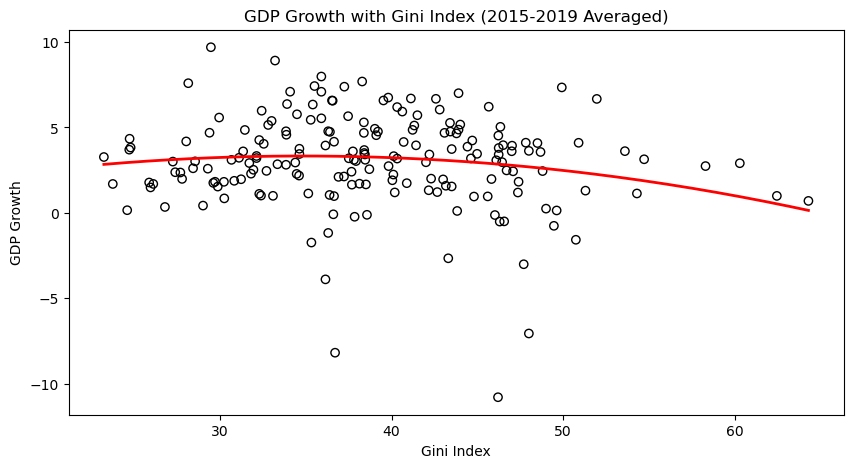

In [9]:
# Dropping missing values
wb_plot = wb_avg.dropna(subset=['GDP_Growth', 'Gini_Index'])

# Defining x and y
x = wb_plot['Gini_Index'].values
y = wb_plot['GDP_Growth'].values

# Fitting quadratic polynomial
coef = np.polyfit(x, y, deg=2)
poly = np.poly1d(coef)

# Generate curve line
x_curve = np.linspace(x.min(), x.max(), 200)
y_curve = poly(x_curve)

# Defining plot and size
plt.figure(figsize=(10,5))

# Defining scatter
plt.scatter(x, y, marker='o', facecolors='none', edgecolors='k')

# Plotting quadratic curve
plt.plot(x_curve, y_curve, color="red", linewidth=2)

# Labels
plt.xlabel('Gini Index')
plt.ylabel('GDP Growth')

# Title
plt.title('GDP Growth with Gini Index (2015-2019 Averaged)')

plt.show()

We can see a weak non-linear relationship which resembles an inverted U-shape.

# Regressions

## 1. Do more unequal income distributions affect an economy's growth?
We estimate:
$$
\begin{aligned}
{\overline{\text{GDP\_Growth}}}_{i}
&= \hat{\beta}_0
+ \hat{\beta}_1 \,\overline{\text{Gini}}_{i}
+ \hat{\beta}_2 \,\overline{\text{Gini}}^{\,2}_{i}
+ \hat{\beta}_3 \log(\overline{\text{GDP\_Pc}}_{i})
+ \hat{\beta}_4 \log(\overline{\text{Educ\_Exp}}_{i}) \\
&\quad
+ \hat{\beta}_5 \log(\overline{\text{Trade}}_{i})
+ \hat{\beta}_6 \,\overline{\text{Govt\_Effectiveness}}_{i}
+ \hat{\beta}_7 \left(\overline{\text{Educ\_Exp}}_{i} \times \overline{\text{Govt\_Effectiveness}}_{i}\right)
+ u_i
\end{aligned}
$$



In [10]:
# Statistical significance helper function
def stat_significance(est):
    p_values = est.pvalues
    for feature, p in p_values.items():
        if p <= 0.01:
            print(f"{feature}: {p} -- Reject at 1% significance level\n")
        elif p <= 0.05:
            print(f"{feature}: {p} -- Reject at 5% significance level\n")
        elif p<= 0.1:
            print(f"{feature}: {p} -- Reject at 10% significance level\n")
        else:
            print(f"{feature}: {p} -- Fail to reject at 10% significance level\n")


In [91]:
# Question 1

# Setting up formula
formula_1 = (""
           "GDP_Growth ~ Gini_Index + Gini_Sq + "
           "GDP_Pc_Log + Educ_Log + Trade_Log + "
             "Govt_Effectiveness + Educ_Govt_Eff"
             )

# List of variables on which to drop rows (interaction excluded)
vars_1 = ['GDP_Growth', 'Gini_Index', 'Gini_Sq',
        'GDP_Pc_Log', 'Educ_Log', 'Trade_Log', 'Govt_Effectiveness']

# Rows before
before = wb_avg.shape[0]

# Dropping only regression variable subset - listwise deletion
wb_q1 = wb_avg.dropna(subset=vars_1)

# Rows after
after = wb_q1.shape[0]

# Expressing rows dropped as percentage
per_dropped = ((before - after) / before ) * 100
print(f"We dropped {per_dropped:.2f}% rows")

# Creating design matrices
y, X = dmatrices(formula_1, data=wb_q1, return_type='dataframe')

# Defining OLS model
model_1 = sm.OLS(y, X)

# Estimating
estimate_1 = model.fit()

print(estimate_1.summary())

stat_significance(estimate_1)

We dropped 20.93% rows
                            OLS Regression Results                            
Dep. Variable:             GDP_Growth   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     8.870
Date:                Sat, 22 Nov 2025   Prob (F-statistic):           3.16e-09
Time:                        16:06:42   Log-Likelihood:                -376.89
No. Observations:                 170   AIC:                             769.8
Df Residuals:                     162   BIC:                             794.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept    

# 1a. Are the residuals heteroskedastic?
We run White's test and then re-estimate the moel using robust standard errors if yes ....

In [98]:
## Testing for heteroskedasticity

# White's test
lm_stat, lm_p, f_stat, f_p = het_white(estimate.resid, X)

print(f"White LM P-value: {lm_p}")
print(f"White F-test P-value: {f_p}")
# We reject the null of homoskedasticity at all levels of significance

# Estimating with robust standard errors
estimate_robust = model.fit(cov_type='HC1')
print(estimate_robust.summary())

stat_significance(estimate_robust)

White LM P-value: 9.193359556985656e-09
White F-test P-value: 1.243616099995026e-14
                            OLS Regression Results                            
Dep. Variable:             GDP_Growth   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     21.43
Date:                Sat, 22 Nov 2025   Prob (F-statistic):           2.71e-20
Time:                        16:14:30   Log-Likelihood:                -376.89
No. Observations:                 170   AIC:                             769.8
Df Residuals:                     162   BIC:                             794.9
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

We saw that the errors were heteroskedastic so ... changes ...

# 1b. Does inequality and its non-linear transformation jointly influence growth?
We are here testing the joint hypothesis that both the coefficient on Gini and Gini squared is significantly different from 0.

In [94]:
F_results = estimate_robust.f_test("Gini_Index = 0, Gini_Sq = 0")
print(F_results)

<F test: F=3.0463429127964865, p=0.05026457803442638, df_denom=162, df_num=2>


We fail reject the null at 10% significance level that both coefficients for Gini and Gini squared are significantly different from 0. There is some evidence that Gini and its non-linear transformation jointly affect growth

# 1c. Is inequality's effect on GDP Growth non-linear?
To answer this we do a hypothsis test:
(hypothesis test)


In [100]:
t_results = estimate_robust.t_test("Gini_Sq = 0")
print(t_results)

                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0029      0.002     -1.817      0.069      -0.006       0.000


# 1d. Why were inference tests in our summary table unreliable?
This is because Gini and Gini squared are almost perfectly colinear. The OLS estimator was imprecise, the standard errors were exceptionally high which led to unreliable inference. When we took a joint F-test we were looking at the joint effect they had on growth, so their variation combined was used to explain the variation in the dependent variable. This approach did not need to distinguish between which of the two variables was having which effect, which couldn't be done individually since they were close to perfect correlation. We can even see this in the next block of code...

In [102]:
corr_gini = wb_q1['Gini_Index'].corr(wb_q1['Gini_Sq'])
print(corr_gini)

0.9905074992627813


## 2. Does greater international trade integration **within a country** lead to higher FDI inflows?
We estimate:

$$
\begin{aligned}
\log(\text{FDI}_{it})
&= \widehat{\beta}_0
+ \widehat{\beta}_1 \log(\text{Trade}_{it})
+ \widehat{\beta}_2 \log(\text{GDP\_Pc}_{it})
+ \widehat{\beta}_3 \,\text{Gini}_{it}
+ \widehat{\beta}_4 \,\text{Gini}^{2}_{it}
+ \widehat{\beta}_5 \,\text{Rule\_Of\_Law}_{it}
\\[1em]
&\quad
+ \widehat{\beta}_6 \left( \text{Rule\_Of\_Law}_{it} \times \log(\text{GDP\_Pc}_{it}) \right)
+ \widehat{\beta}_7 \left( \log(\text{Trade}_{it}) \times \text{Rule\_Of\_Law}_{it} \right)
+ \alpha_i
+ \lambda_t
+ \widehat{\varepsilon}_{it}
\end{aligned}
$$

In [87]:
# Question 2

# Setting up formula
formula_2 = (""
           "FDI_Log ~ Trade_Log + GDP_Pc_Log + "
           "Gini_Index + Gini_Sq + Rule_Of_Law + "
             "GDP_Law + Trade_Law"
             )

# List of variables on which to drop rows (interaction excluded)
vars_2 = ['FDI_Log', 'Trade_Log', 'GDP_Pc_Log',
        'Gini_Index', 'Gini_Sq', 'Rule_Of_Law',
          'GDP_Law', 'Trade_Law']

# Dropping only regression variable subset - listwise deletion
wb_q2 = wb_imputed.dropna(subset=vars_2)

# Setting multi-index
wb_q2 = wb_q2.set_index(['iso3', 'year'])

# Rows after dropping missing values
after = wb_q2.shape[0]

# Expressing rows dropped as percentage
per_dropped = ((before - after) / before ) * 100
print(f"We dropped {per_dropped:.2f}% rows")

# Creating design matrices
y, X = dmatrices(formula_2, data=wb_q2, return_type='dataframe')

# Defining OLS model
model_2 = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)

# Estimating
estimate_2 = model_2.fit(cov_type='clustered', cluster_entity=False)

print(estimate_2.summary)

stat_significance(estimate_2)

We dropped 20.69% rows
                          PanelOLS Estimation Summary                           
Dep. Variable:                FDI_Log   R-squared:                        0.0159
Estimator:                   PanelOLS   R-squared (Between):              0.0832
No. Observations:                3581   R-squared (Within):               0.0241
Date:                Sat, Nov 22 2025   R-squared (Overall):              0.0448
Time:                        15:55:23   Log-likelihood                   -5094.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      7.7780
Entities:                         174   P-value                           0.0000
Avg Obs:                       20.580   Distribution:                  F(7,3380)
Min Obs:                       5.0000                                           
Max Obs:                       21.000   F-statistic (robust):             9.4039
     

# 2a. What is the interpretation of the fixed effect constants?


In [90]:
# Extracting fixed effects
effects_est = estimate_2.estimated_effects

# Printing first few rows
print(effects_est.head(20))

           estimated_effects
iso3 year                   
AFG  2002          -0.656935
     2003          -0.641077
     2004          -0.466811
     2005          -0.336210
     2006          -0.081283
     2007           0.033667
     2008          -0.098895
     2009          -0.376883
     2010          -0.398995
     2011          -0.246179
     2012          -0.279295
     2013          -0.463510
     2014          -0.441084
     2015          -0.427937
     2016          -0.414770
     2017          -0.455054
     2018          -0.641817
     2019          -0.539043
     2020          -0.971656
     2021          -0.450024


WRITE INTERPRETATION entity fixed effects vary through time

# 2b. Is the model overfitting?
LASSO and Ridge

In [ ]:
# Testing for Robustness using LASSO

## 3. Does higher spending on education **within a country** translate to increased growth?
\begin{aligned}
\text{GDP\_Growth}_{it}
&= \widehat{\beta}_0
+ \widehat{\beta}_1 \,\text{Educ\_Log}_{it}
+ \widehat{\beta}_2 \,\text{Trade\_Log}_{it}
+ \widehat{\beta}_3 \,\text{Gini\_Index}_{it}
+ \widehat{\beta}_4 \,\text{Gini\_sq}_{it}
+ \widehat{\beta}_5 \,\text{Govt\_Effectiveness}_{it}
\\[1em]
&\quad
+ \widehat{\beta}_6 \left( \text{Educ\_Log}_{it} \times \text{Govt\_Effectiveness}_{it} \right)
+ \alpha_i
+ \lambda_t
+ \widehat{\varepsilon}_{it}
\end{aligned}

In [69]:
# Question 3

# Setting up formula
formula_3 = (""
           "GDP_Growth ~ Educ_Log + Trade_Log + "
           "Gini_Index + Gini_Sq + Govt_Effectiveness + "
             "Educ_Govt_Eff"
             )

# List of variables on which to drop rows (interaction excluded)
vars_3 = ["GDP_Growth", 'Educ_Log', 'Trade_Log',
          'Gini_Index', 'Gini_Sq', 'Govt_Effectiveness',
          'Educ_Govt_Eff']

# Dropping only regression variable subset - listwise deletion
wb_q3 = wb_imputed.dropna(subset=vars_3)

# Setting multi-index
wb_q3 = wb_q3.set_index(['iso3', 'year'])

# Rows after
after = wb_q3.shape[0]

# Expressing rows dropped as percentage
per_dropped = ((before - after) / before ) * 100
print(f"We dropped {per_dropped:.2f}% rows")

# Creating design matrices
y, X = dmatrices(formula_3, data=wb_q3, return_type='dataframe')

# Defining OLS model
model_3 = PanelOLS(y, X, entity_effects=True, drop_absorbed=True)

# Estimating
estimate_3 = model_2.fit(cov_type='clustered', cluster_entity=False)

print(estimate_3.summary)

stat_significance(estimate_3)

We dropped 21.66% rows
                          PanelOLS Estimation Summary                           
Dep. Variable:                FDI_Log   R-squared:                        0.0270
Estimator:                   PanelOLS   R-squared (Between):              0.0161
No. Observations:                3581   R-squared (Within):               0.0270
Date:                Sat, Nov 22 2025   R-squared (Overall):              0.0235
Time:                        15:40:44   Log-likelihood                   -5171.6
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      13.495
Entities:                         174   P-value                           0.0000
Avg Obs:                       20.580   Distribution:                  F(7,3400)
Min Obs:                       5.0000                                           
Max Obs:                       21.000   F-statistic (robust):             13.494
     

# 3a. Is there endogeneity and how do we address it?

We expect there to be endogeneity in the model. GDP Growth and Education Expenditure exhibit simultaneity since they have a two-way casual effect. This biases the estimates and makes the OLS estimators inconsistent. We would have to introduce an instrument that is relevant, strongly related with Education Expenditure, and valid, only affects GDP growth through Education Expenditure. A candidate instrument we will use is the lagged version of the log of Education Expenditure. We expect that the Education expenditure in the previous year will not affect the economic growth of this year. We also expect that the expenditure on Education this year will be related to that of last year's.

We set the instrument for Education Expenditure as:
$Z_{1, it} = \text{Educ\_Log}_{i(t-1)}$

Its first stage equation:
$\begin{aligned}
\text{Educ\_Log}_{it}
&= \pi_0
+ \pi_1 \,\text{Educ\_Log}_{i,t-1}
+ \boldsymbol{\pi}_2^{\prime} \mathbf{C}_{it}
+ \alpha_i + \lambda_t + u_{it},
\end{aligned}\\[1em]$

$\boldsymbol{\pi}_2^{\prime} \mathbf{C}_{it} = \text{Vector of controls with vector of coefficients}\\[1em]$

And the instrument for the interaction term as:
$
\left( \text{Educ\_Log}_{it} \times \text{Govt\_Effectiveness}_{it} \right)
= \theta_0
+ \theta_1 \left( \text{Educ\_Log}_{i,t-1} \times \text{Govt\_Effectiveness}_{it} \right)
+ \boldsymbol{\theta}_2^{\prime} \mathbf{C}_{it}
+ \alpha_i + \lambda_t + v_{it}\\[1em]
$

$\boldsymbol{\theta}_2^{\prime} \mathbf{C}_{it} = \text{Vector of controls with vector of coefficients}\\[1em]$

In [75]:
from statsmodels.api import add_constant
# Recreating dataframe for replicability
wb_q3 = wb_imputed.copy()
wb_q3 = wb_q3.dropna(subset=vars_3)

#Reseting index
wb_q3.reset_index(inplace=True, drop=True)
## Creating lagged education variable

# Grouping by country code and education expenditure and shifting up by 1 (if for replicability)
wb_q3['Educ_Lag1'] = wb_q3.groupby('iso3')['Educ_Log'].shift(1)

# Checking for missing values
print(wb_q3['Educ_Lag1'].isna().sum())
# IV2SLS handles missing values, no need to do anything

# Creating lagged interaction
wb_q3['Educ_Govt_Lag'] = wb_q3['Educ_Lag1'] * wb_q3['Govt_Effectiveness']

## Defining model specifications

# Adding constant
wb_q3 = add_constant(wb_q3, has_constant='add')

# Controls
controls = wb_q3[['const', 'Trade_Log', 'Gini_Index', 'Gini_Sq', 'Govt_Effectiveness']]

# Endogenous variables
endog = wb_q3[['Educ_Log', 'Educ_Govt_Eff']]

#Instruments
instruments = wb_q3[['Educ_Lag1', 'Educ_Govt_Lag']]

# IV model
model_IV = IV2SLS(wb_q3['GDP_Growth'],
                  controls,
                  endog,
                  instruments)

# Fitting model
estimate_IV = model_IV.fit(cov_type='robust')

# Fitted model summary
print(estimate_IV.summary)

# Statistical significance of each coefficient
stat_significance(estimate_IV)

# First stage result
print(estimate_IV.first_stage.summary)
# Instruments are very strong

170
                          IV-2SLS Estimation Summary                          
Dep. Variable:             GDP_Growth   R-squared:                      0.0285
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0267
No. Observations:                3367   F-statistic:                    106.65
Date:                Sat, Nov 22 2025   P-value (F-stat)                0.0000
Time:                        15:44:48   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                  
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
const                 -6.4910     2.2015    -2.9485     0.0032     -10.806     -2.1762
Trade_Log       

C:\Users\andre\anaconda3\Lib\site-packages\linearmodels\iv\model.py:560: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(


           First Stage Estimation Results           
                              Educ_Log Educ_Govt_Eff
----------------------------------------------------
R-squared                       0.9845        0.9980
Partial R-squared               0.9829        0.9976
Shea's R-squared                0.8864        0.8997
Partial F-statistic          3.265e+05     4.833e+05
P-value (Partial F-stat)        0.0000        0.0000
Partial F-stat Distn           chi2(2)       chi2(2)
========================== ===========   ===========
const                           0.3096        0.0090
                              (3.1414)      (0.1936)
Trade_Log                      -0.0155       -0.0013
                             (-3.4629)     (-0.3274)
Gini_Index                     -0.0073       -0.0009
                             (-1.5931)     (-0.5293)
Gini_Sq                      8.512e-05     9.677e-06
                              (1.4187)      (0.4448)
Govt_Effectiveness              0.0449       -

# Interpretation

# References:
The World Bank (2025) Poverty and Inequality – World Development Indicators. Available at: https://datatopics.worldbank.org/world-development-indicators/themes/poverty-and-inequality.html
 (Accessed: 9 November 2025).

The World Bank (2025) People – World Development Indicators. Available at: https://datatopics.worldbank.org/world-development-indicators/themes/people.html
 (Accessed: 9 November 2025).

https://data.worldbank.org/indicator/

World Bank (2024) Worldwide Governance Indicators: Documentation. Available at: https://www.worldbank.org/en/publication/worldwide-governance-indicators/documentation
 (Accessed: 14 November 2025).

World Bank (2020) Rule of Law: Estimate – Documentation. Available at: https://www.worldbank.org/content/dam/sites/govindicators/doc/rl.pdf
 (Accessed: 14 November 2025).

World Bank (2024) Government Effectiveness: Representative Sources. Available at: https://www.worldbank.org/content/dam/sites/govindicators/doc/ge.pdf
 (Accessed: 14 November 2025).

World Bank (2025) Foreign direct investment, net inflows (% of GDP) [Indicator: BX.KLT.DINV.WD.GD.ZS]. World Development Indicators. Available at: https://data.worldbank.org/indicator/BX.KLT.DINV.WD.GD.ZS
 (Accessed: 14 November 2025).

Solt, Frederick, 2019, "The Standardized World Income Inequality Database, Versions 8-9", https://doi.org/10.7910/DVN/LM4OWF, Harvard Dataverse, V14; x_swiid9_8.zip [fileName]

Wooldridge, J.M. (2015) Introductory Econometrics: A Modern Approach. 6th edn. Boston, MA: Cengage Learning.

Kennedy, P. (2008) A Guide to Econometrics. 6th edn. Malden, MA: Blackwell Publishing.

Banerjee, A. and Duflo, E. (2003) ‘Inequality and growth: what can the data say?’, Journal of Economic Growth, 8(3), pp. 267–299.

Bellemare, M.F. and Wichman, C.J. (2020) ‘Elasticities and the inverse hyperbolic sine transformation’, Oxford Bulletin of Economics and Statistics, 82(1), pp. 50–61. doi: 10.1111/obes.12325.

https://github.com/pycountry


https://blogs.worldbank.org/en/opendata/world-bank-country-classifications-by-income-level-for-2024-2025

https://worldpopulationreview.com/country-rankings/gdp-per-capita-by-country

https://www.imf.org/external/datamapper/NGDP_RPCH@WEO/LIE?zoom=LIE&highlight=LIE



https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes
